In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

In [2]:
filename = 'audio/simple_piano.wav'
x, sr = librosa.load(filename)

In [3]:
ipd.Audio(x, rate=sr)

In [4]:
bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)

E:\Kameswar\Anaconda3\lib\site-packages\librosa\core\spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
cqt.shape

(300, 166)

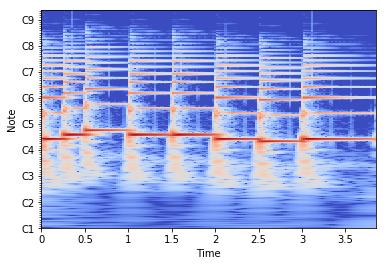

In [6]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

In [7]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

(0, 850)

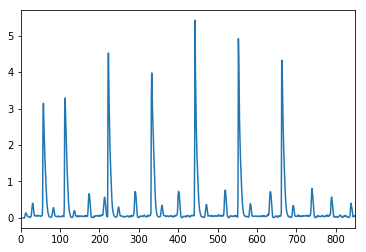

In [8]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

In [9]:
onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

In [10]:
onset_samples

array([ 5800, 11300, 22300, 33300, 44300, 55300, 66400])

In [11]:
onset_boundaries = numpy.concatenate([[0], onset_samples, [len(x)]])

In [12]:
print (onset_boundaries)

[    0  5800 11300 22300 33300 44300 55300 66400 84928]


In [13]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)

In [14]:
onset_times

array([0.        , 0.26303855, 0.51247166, 1.01133787, 1.51020408,
       2.00907029, 2.50793651, 3.01133787, 3.85160998])

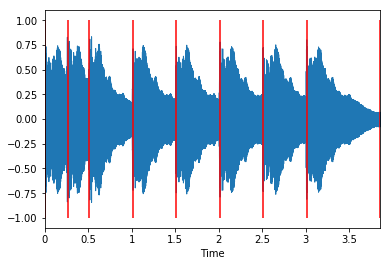

In [15]:
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

In [16]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

In [17]:
def generate_sine(f0, sr, n_duration):
    n = numpy.arange(n_duration)
    return 0.2*numpy.sin(2*numpy.pi*f0*n/float(sr))

In [18]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

In [19]:
y = numpy.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

In [20]:
ipd.Audio(y, rate=sr)

In [21]:
cqt = librosa.cqt(y, sr=sr)

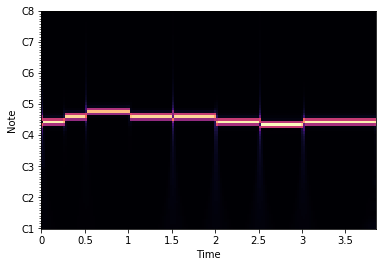

In [22]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')